In [ ]:
!pip install --upgrade tensorflow==2.12.0 --quiet

In [ ]:
# Check for GPU
!nvidia_smi -L

/bin/bash: nvidia_smi: command not found


# 10. Milestone Project 3: Time series forecasting in TensorFlow

## Plan of all stages in this notebook
 - Get time series data (the historical price of Bitcoin)
    * Load in time series data using pandas/Python's CSV module

- Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate (more than one variable) data

- Evaluating a time series forecasting model
- Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing

- Creating a modelling checkpoint to save the best performing model during training
- Making predictions (forecasts) with a time series model
- Creating prediction intervals for time series model forecasts
- Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
- Demonstrating why forecasting in an open system is BS (the turkey problem)


## Get data

In [ ]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv --quiet

### Importing time series data with pandas

In [ ]:
import pandas as pd
# Parse dataes and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])  # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
# Look at info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples dataset have
len(df)

2787

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


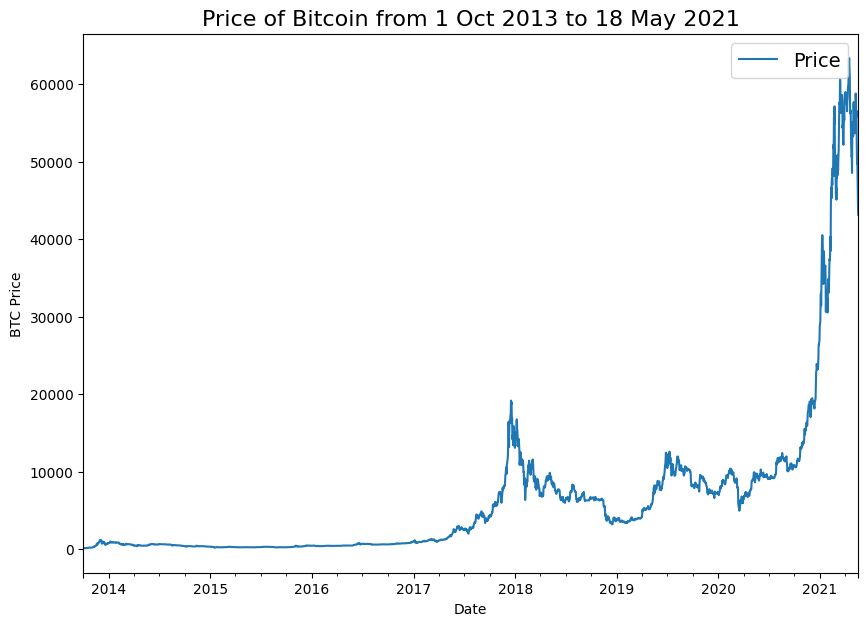

In [ ]:
# Plot everything in dataset
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [ ]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')  # read in the target CSV
    next(csv_reader)  # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))  # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[2]))  # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0, 0.5, 'BTC Price')

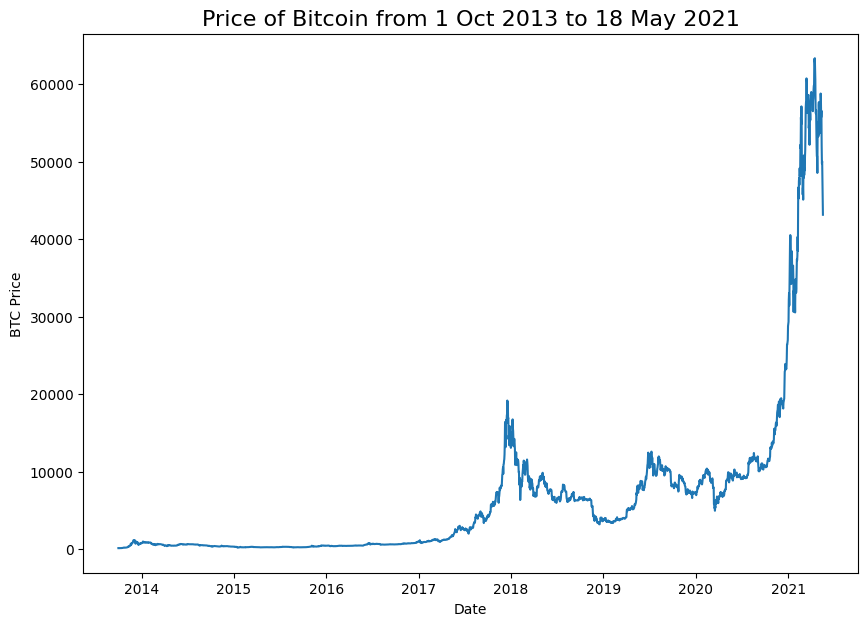

In [ ]:
# Plot from CSV
import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price")

## Format Data Part 1: Creatining train and test sets for time series data

### Create train & test sets for time series (the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets fro time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,  # dates
                                                    prices,  # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

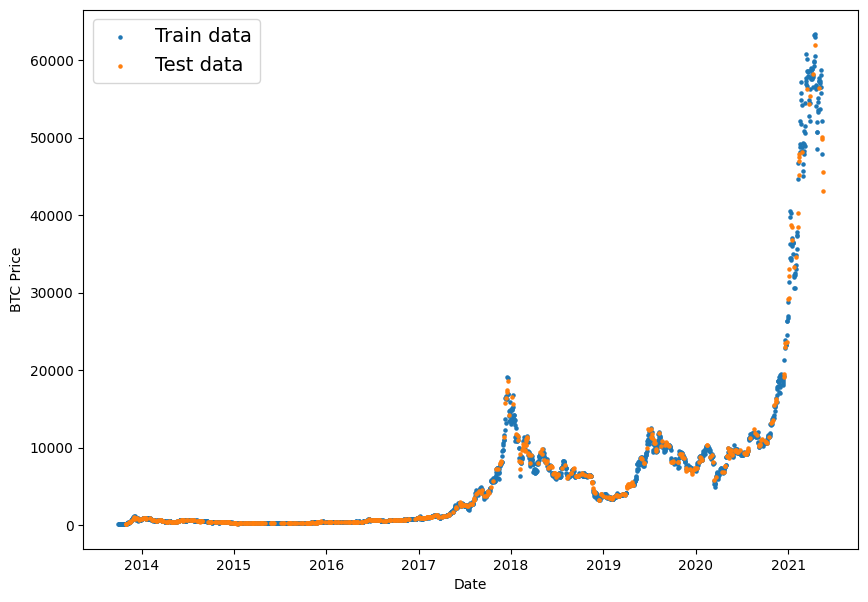

In [ ]:
# Let's plot wrong trian and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)

### Create train & test sets for time series (the right way)

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))  # 80% trian, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

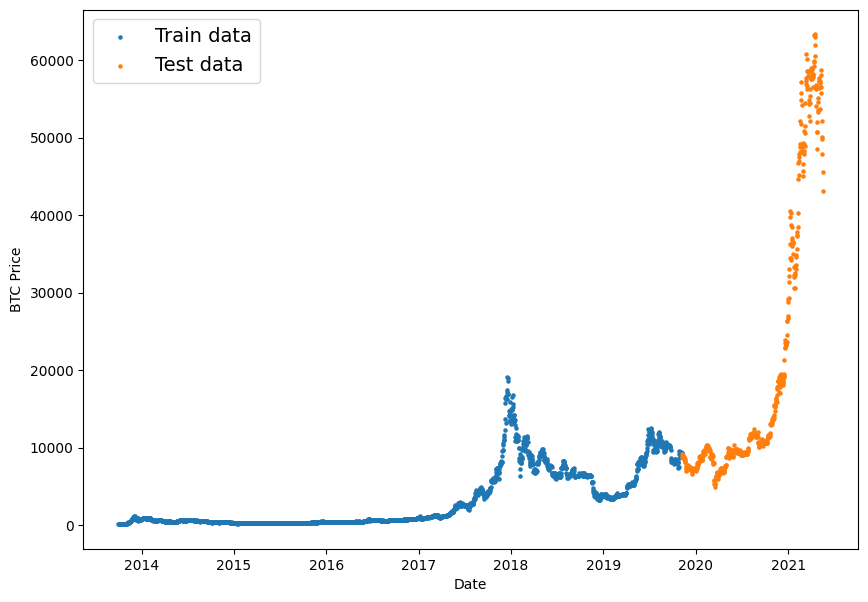

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)

#### Create a plotting function

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps);

    :param timesteps: array of timesteps;
    :param values: array of values across time;
    :param format: style of plot, default '.';
    :param start: where to start the plot (setting a value will index from start of timesteps & values);
    :param end: where to end the plot (setting a value will index from and of timesteps & values)
    :param label: label to show on plot of values.
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)  # make label bigger
    plt.grid(True)

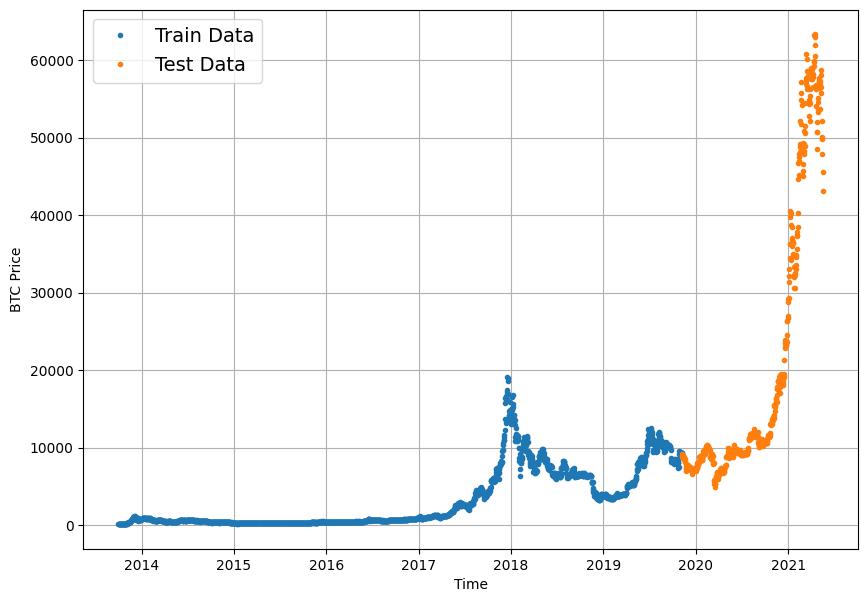

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ------------ | ---------- | --- | --- | --- |
| 0 |	Naïve model (baseline)|  NA          | NA          | NA |
| 1 |	Dense model           |	1            | 7           | NA |
| 2 |	Same as 1             | 1            | 30          | NA |
| 3 |	Same as 1             | 7            | 30          | NA |
| 4 |	Conv1D                |	1            |	7          | NA |
| 5 |	LSTM                  | 1            |	7          | NA |
| 6 |	Same as 1 (multivariate data) |	1    |	7          | Block reward size |
| 7 | N-BEATs Algorithm     |	1            |	7          | NA |
| 8 |	Ensemble (multiple modelsoptimized on different loss functions) |	1        |	7          | NA |
| 9 | Future prediction model (model to predict future values) |	1        |	7          | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1            |	7          | NA |

### Model 0: Naïve forecast (baseline)

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1]  # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]  # View first 10  and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

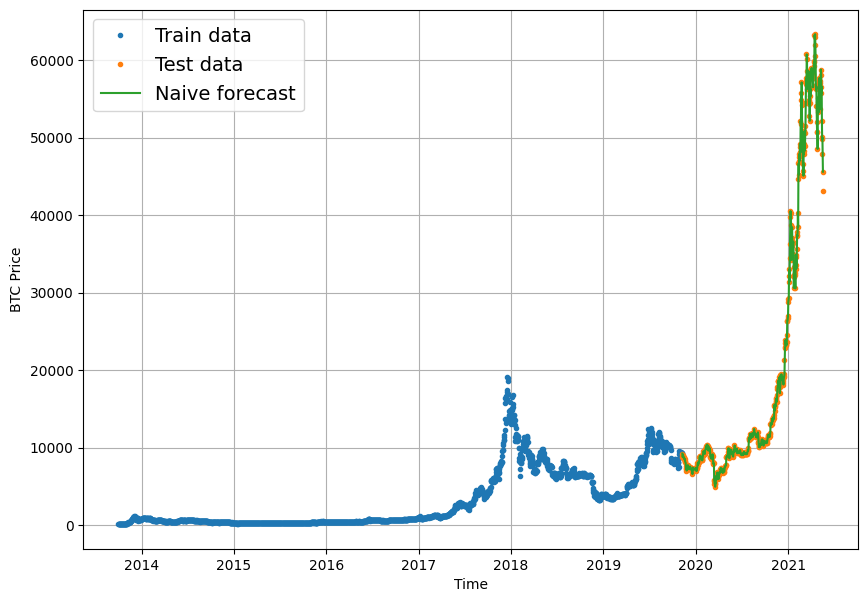

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label="Naive forecast")

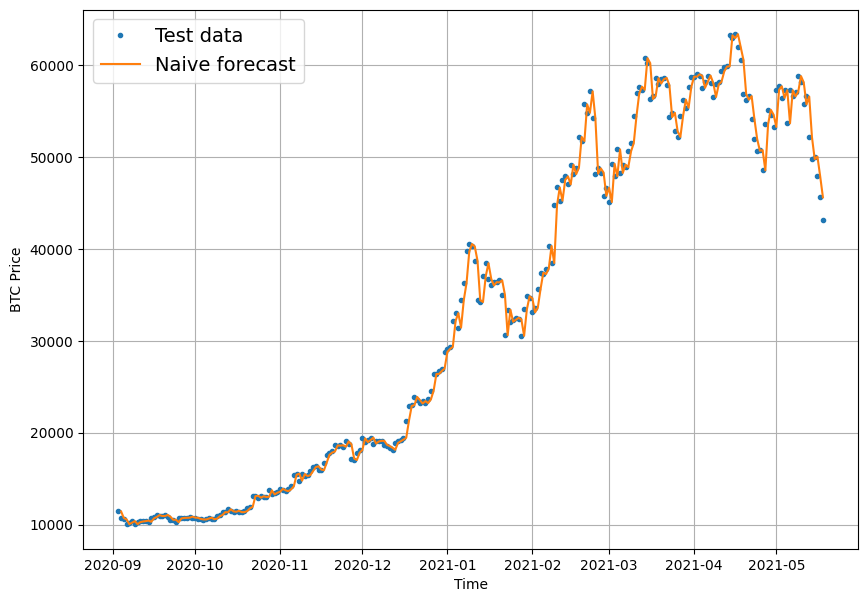

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300  # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', start=offset, label="Naive forecast")

## Evaluating a time series model

### Scale-dependent errors


| Metric | Details | Code |
| ------ | ------- | ---- |
| MAE (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt( tf.keras.metrics.mean_square_error() )` |

### Percentage errors

| Metric | Details | Code |
| ------ | ------- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | tf.keras.metrics.mean_absolute_percentage_error() |
| sMAPE (symmetric mean absolute percantage error) | Recommended not to be used by `Forecasting: Principles and Practice`, though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

| Metric | Details | Code |
| ------ | ------- | ---- |
| MASE (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's `mase_loss()` |

In [ ]:
import tensorflow as tf

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data) with TensorFLow.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
    """
    Build dictionary with all metrics for our models to evaluate their performance
    """
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)  # puts and emphasis on outliers (all errorss get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy(),}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

### Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name | Resource |
| ------------------ | -------- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

In [ ]:
HORIZON = 1  # predict 1 step at a time
WINDOW_SIZE = 7  # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(X, horizon=1):
    """
    Creates labels for windowed dataset.
    E.g. if horizon=1 (default)
    then Input: [1, 2, 3, 4, 5, 6] --> Output: ([1, 2, 3, 4, 5], [6])
    """
    return X[:, :-horizon], X[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} --> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] --> Label: 8


*Resource*: The fucntion created below has been adapted from Syafiq Kamarul Azman's article [Fast and Robust Sliding Window Vectorization with NumPy](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    # print(f"Window step:/n {window_step{}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T  # create 2D array of windows of size window_size
    # print(f"Window indexs:/n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} --> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} --> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] --> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] --> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] --> Label: [43144.47129086]


### Turning windows into training and test sets

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into trian and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))  # this will default to 80% train/ 20% test

    train_windows = windows[:split_size]
    train_labels = labels[:split_size]

    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON - 1]), y_train[WINDOW_SIZE:])

True

## Make a modeling checkpoint

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callbac with a specific filename
def create_model_checkpoint(model_name, save_path="content/model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),  # create filepath to save model
                                              verbose=0,  # only output a limited amount of text
                                              save_best_only=True)  # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

In [ ]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear")  # linear activation is the same as having no activation
], name="model_1_dense")  # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae"])

In [ ]:
# Fit model
model_1.fit(x=train_windows,  # train windows of 7 timesteps of Bitcoin prices
            y=train_labels,  # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])  # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 5s 73ms/step - loss: 1600.5013 - mae: 1600.5013 - val_loss: 3062.6123 - val_mae: 3062.6123
Epoch 2/100
18/18 [==============================] - 1s 30ms/step - loss: 387.1668 - mae: 387.1668 - val_loss: 1549.0133 - val_mae: 1549.0133
Epoch 3/100
18/18 [==============================] - 1s 31ms/step - loss: 193.9897 - mae: 193.9897 - val_loss: 1139.6132 - val_mae: 1139.6132
Epoch 4/100
18/18 [==============================] - 1s 37ms/step - loss: 173.9508 - mae: 173.9508 - val_loss: 933.5021 - val_mae: 933.5021
Epoch 5/100
18/18 [==============================] - 1s 44ms/step - loss: 166.8027 - mae: 166.8027 - val_loss: 913.9772 - val_mae: 913.9772
Epoch 6/100
18/18 [==============================] - 1s 42ms/step - loss: 164.5806 - mae: 164.5806 - val_loss: 885.7348 - val_mae: 885.7348
Epoch 7/100
18/18 [==============================] - 1s 41ms/step - loss: 157.5651 - mae: 157.5651 - val_loss: 872.1451 - val_mae: 872.1451
Epoch 8/100


In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 691.9128 - mae: 691.9128


[691.912841796875, 691.912841796875]

In [ ]:
from keras.models import load_model
# Load in saved best performing model_1 and evaluate on test data
model_1 = load_model("content/model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 567.8511 - mae: 567.8511


[567.85107421875, 567.85107421875]

### Making forecasts with a model (on the test dataset)

In [ ]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    :param model: trained model;
    :param input_data: windowed input data (same kind of data model was trained on);
    :return: model predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8869.174 , 8770.512 , 9036.634 , 8838.744 , 8744.24  , 8727.1455,
        8707.348 , 8532.635 , 8463.7   , 8535.389 ], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),  # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 567.85114,
 'mse': 1173786.4,
 'rmse': 1083.4142,
 'mape': 2.5389447,
 'mase': 0.99755716}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

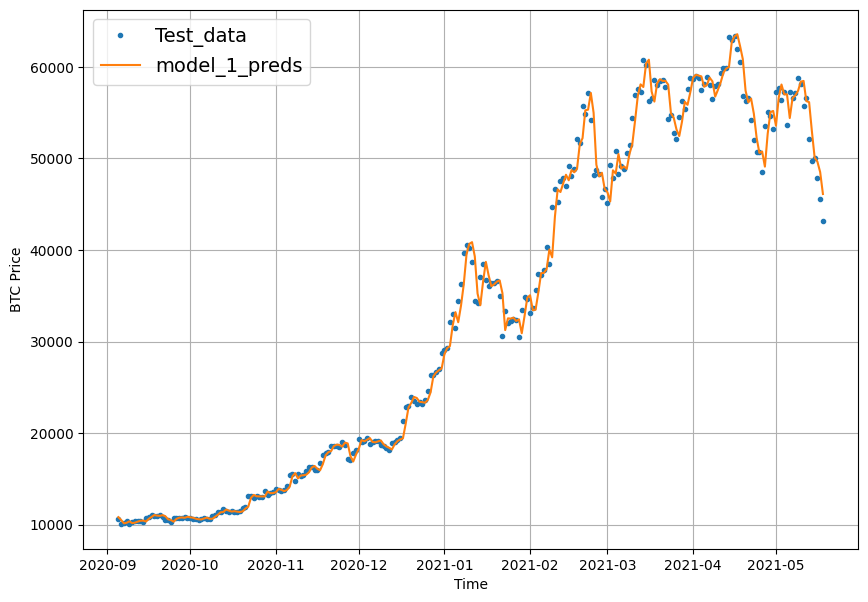

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1  # predict one step at a time
WINDOW_SIZE = 30  # use 30 timesteps in the past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

### Construct model_2

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON)  # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 708.9117


708.9117431640625

In [ ]:
# Load in best performing model
model_2 = load_model("content/model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 616.9835


616.9834594726562

In [ ]:
# Get forecast predicitons
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 3ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),  # remove 1 dimentsion of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 616.98334,
 'mse': 1296033.4,
 'rmse': 1138.4346,
 'mape': 2.8021014,
 'mase': 1.0784929}

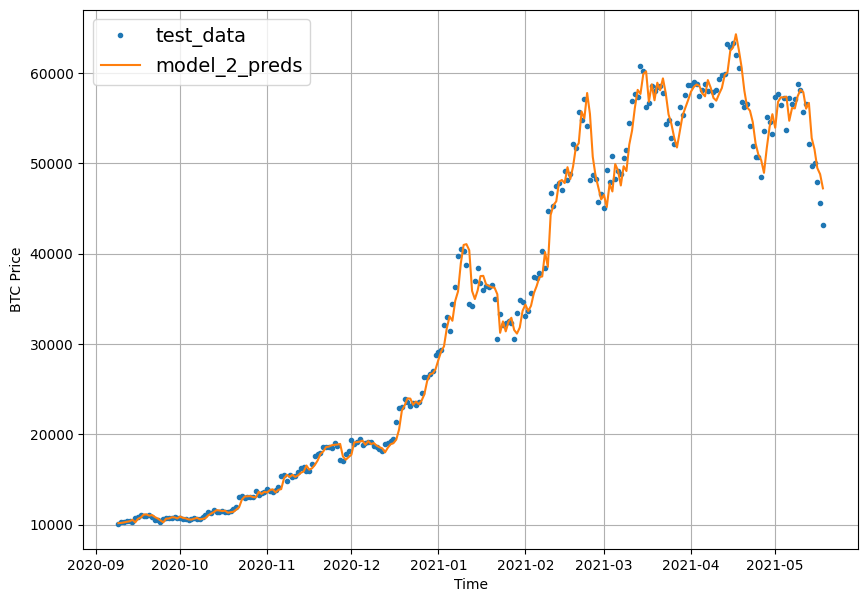

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# View how did our model with a larget window size and horizon go
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1383.2302


1383.230224609375

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = load_model("content/model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1228.3522


1228.3521728515625

In [ ]:
# The predicitons are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9301.33  , 9490.038 , 9512.726 , 9380.52  , 9658.367 , 9623.504 ,
        9727.368 ],
       [9071.387 , 9081.091 , 8983.298 , 9007.569 , 9293.866 , 9255.2295,
        9418.447 ],
       [8707.3955, 9026.581 , 8795.442 , 8852.412 , 9090.161 , 9003.4375,
        9025.049 ],
       [8774.988 , 9153.874 , 9025.935 , 9079.078 , 9225.515 , 9134.309 ,
        9004.21  ],
       [8824.163 , 8959.886 , 9005.891 , 8897.248 , 9088.959 , 9046.253 ,
        8801.211 ]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  734.4782  ,   407.46988 ,   331.15024 ,   430.24945 ,
          391.88226 ,   538.86115 ,   506.0551  ,   467.0524  ,
          542.0309  ,   591.6454  ,   855.55334 ,   809.6862  ,
          795.681   ,   826.125   ,   550.4697  ,   222.37416 ,
          209.53906 ,   278.66483 ,   265.14963 ,   301.3646  ,
          145.83308 ,   176.40465 ,   294.46832 ,   319.24664 ,
          192.42787 ,    93.29918 ,   116.79039 ,   143.27895 ,
          122.14244 ,   208.11963 ,   292.55936 ,   396.83566 ,
          310.56186 ,   374.96805 ,   277.97574 ,   252.50105 ,
          279.4025  ,   268.81976 ,   194.87277 ,   187.86649 ,
          494.0397  ,    63.576103,    78.185616,    66.00042 ,
          130.19824 ,    89.132675,    73.18575 ,   124.975235,
           97.15221 ,   115.42027 ,   133.73088 ,   127.28369 ,
          202.82652 ,   142.53871 ,   243.13672 ,   344.45285 ,
          585.88855 ,   516.47064 ,   484.72385 ,   570.11444 ,
          393.79938 ,   268.06223

## Make our evaluation function work for larger horizons

In [ ]:
def evaluate_preds(y_true, y_preds):

    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_preds = tf.cast(y_preds, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_preds)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_preds)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_preds)
    mase = mean_absolute_scaled_error(y_true, y_preds)

    # Account for different sized metrics (for larger horizons, reduce to single number)
    if mae.ndim > 0:  # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_preds=model_3_preds)
model_3_results

{'mae': 1228.3522,
 'mse': 5321586.5,
 'rmse': 1412.3005,
 'mape': 5.4986978,
 'mase': 2.1857839}

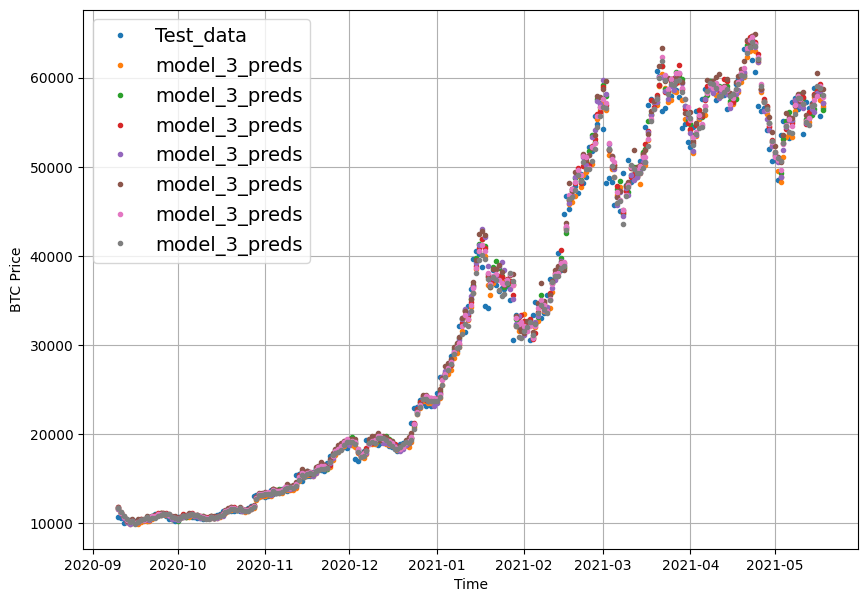

In [ ]:
# Visualize predictions
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

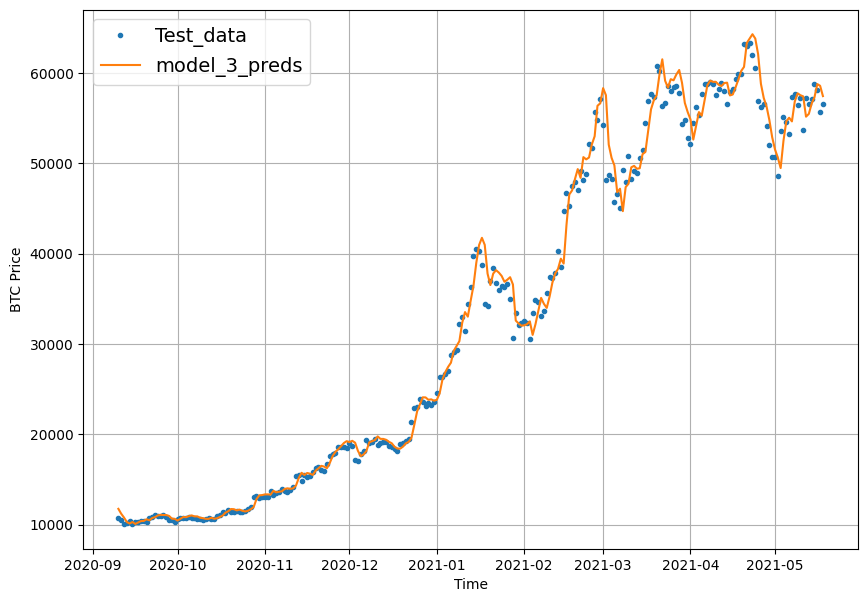

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

<Axes: >

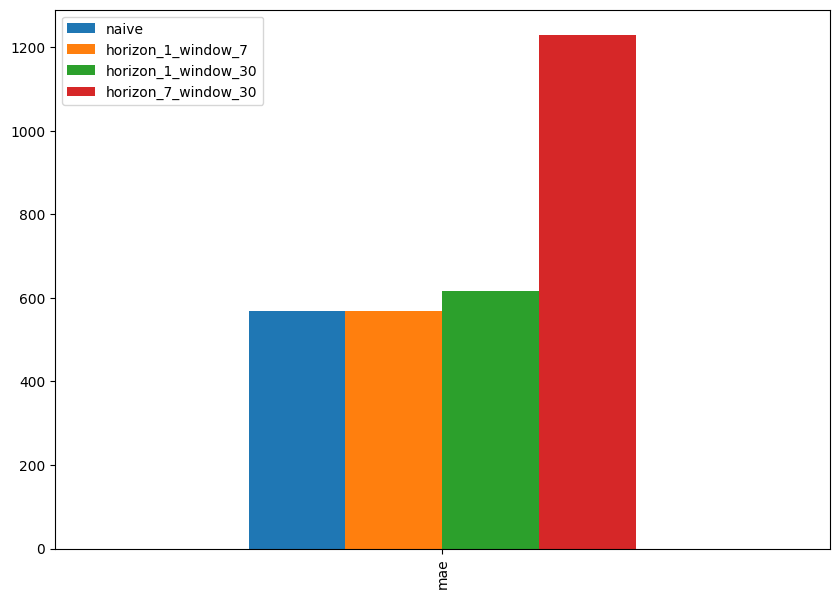

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4: Conv1D

In [ ]:
HORIZON = 1  # predict next day
WINDOW_SIZE = 7  # use prevous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
# Check data sample shapes
train_windows[0].shape  # returns (WINDOW_SIZE, )

(7,)

In [ ]:
from keras.layers import Lambda
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = Lambda(lambda x: tf.expand_dims(x, axis=1))  # add on extra dimension for timesteps
print(f"Original shape: {x.shape}")  # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")  # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


### Construct Conv1D model

In [ ]:
from keras.layers import Conv1D
tf.random.set_seed(42)

# Create model
model_4 = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=1)),  # resize the inputs to adjust for window size / Conv1D 3D input requirements
    Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
# View what does the Lambda layer look like in a summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = load_model("content/model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.2721


570.2720947265625

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8903.165, 8804.477, 9015.837, 8795.497, 8759.32 , 8752.776,
       8693.225, 8542.653, 8480.269, 8529.424], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_preds=model_4_preds)
model_4_results

{'mae': 570.27203,
 'mse': 1182155.1,
 'rmse': 1087.2695,
 'mape': 2.547844,
 'mase': 1.00181}

## Model 5: RNN (LSTM)

In [ ]:
from keras.layers import Input, LSTM
from keras.models import Model
# We reuse the same data we used for the Conv1D model
tf.random.set_seed(42)

# Let's build on LSTM model with the Functional API
inputs = Input(shape=(WINDOW_SIZE))
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)  # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = LSTM(128, activation="relu", return_sequences=True)(x)  # this layer will error if the inputs are not the right shape
x = LSTM(128, activation="relu")(x)  # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = Dense(32, activation="relu")(x)
output = Dense(HORIZON)(x)
model_5 = Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = load_model("content/model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 602.1931


602.193115234375

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8982.568, 8817.294, 8979.777, 8830.529, 8726.434, 8767.504,
       8713.548, 8562.508, 8484.989, 8524.686], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_preds=model_5_preds)
model_5_results

{'mae': 602.19305,
 'mse': 1292138.2,
 'rmse': 1136.7225,
 'mape': 2.7166147,
 'mase': 1.0578864}

### Make a multivariate time series

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Block reward values
block_reward_1 = 50  # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25  # 28 November 2012
block_reward_3 = 12.5  # 9 Jupy 2016
block_reward_4 = 6.25  # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# Get date indexes for when to add different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add  block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block-reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<Axes: xlabel='Date'>

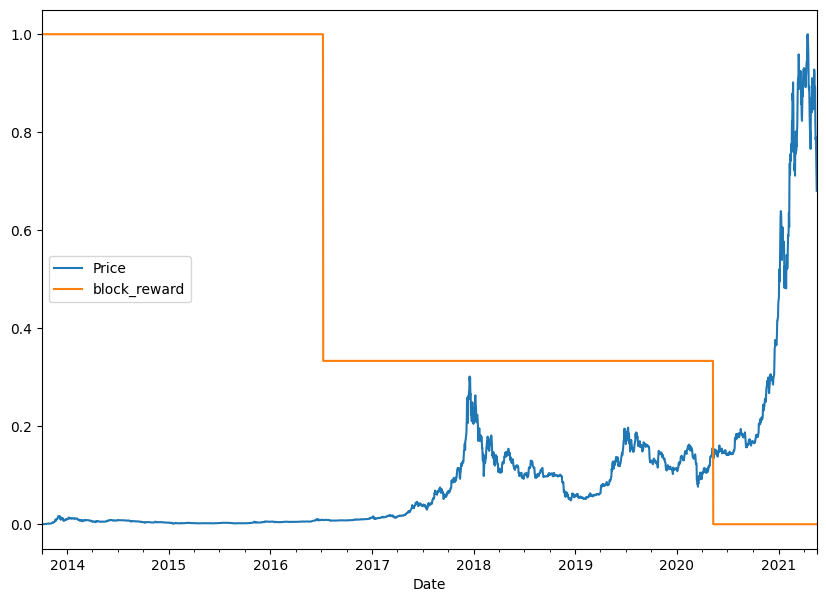

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),  # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Making a windowed dataset with pandas

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):  # Shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = Sequential([
    Dense(128, activation="relu"),
    # Dense(128, activation="relu"),  # adding on extra layer here should lead to beating the naive
    Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [ ]:
# Make sure best model is loaded and evaluate
model_6 = load_model("content/model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 563.8943


563.894287109375

In [ ]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8877.447, 8791.072, 9023.309, 8788.742, 8770.354, 8751.354,
       8686.329, 8537.41 , 8477.526, 8530.279], dtype=float32)>

In [ ]:
# Evaluate predictions
model_6_results = evaluate_preds(y_true=y_test,
                                 y_preds=model_6_preds)
model_6_results

{'mae': 563.8943,
 'mse': 1159228.0,
 'rmse': 1076.6746,
 'mape': 2.5256484,
 'mase': 0.99060607}

In [ ]:
# View how do these results compare to model_1 (same window size and horizon but without the block reward feature)
model_1_results

{'mae': 567.85114,
 'mse': 1173786.4,
 'rmse': 1083.4142,
 'mape': 2.5389447,
 'mase': 0.99755716}

### Exercises
1. True adding an extra `keras.layers.Dense()` layer with 128 hidden units to model_6, how does this effect model performance?
2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward) works better?

#### Exercise - 1

In [ ]:
tf.random.set_seed(42)

model_6_1 = Sequential([
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(HORIZON)
], name="model_6_extndd_dense_multivariate")

# Compile
model_6_1.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_6_1.fit(X_train, y_train,
              epochs=100,
              batch_size=128,
              verbose=0,
              validation_data=(X_test, y_test),
              callbacks=[create_model_checkpoint(model_name=model_6_1.name)])

In [ ]:
# Make sure best model is loaded and evaluate
model_6_1 = load_model("content/model_experiments/model_6_extndd_dense_multivariate")
model_6_1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 568.8962


568.896240234375

In [ ]:
# Make predictions on multivariate data
model_6_1_preds = tf.squeeze(model_6_1.predict(X_test))
model_6_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8809.589 , 8778.694 , 9065.438 , 8735.98  , 8752.963 , 8761.586 ,
       8645.747 , 8524.965 , 8454.8125, 8534.618 ], dtype=float32)>

In [ ]:
# Evaluate predictions
model_6_1_results = evaluate_preds(y_true=y_test,
                                   y_preds=model_6_1_preds)
model_6_1_results

{'mae': 568.8962,
 'mse': 1162402.8,
 'rmse': 1078.1478,
 'mape': 2.546071,
 'mase': 0.99939305}

In [ ]:
# View how do these results compare to model_1
model_1_results

{'mae': 567.85114,
 'mse': 1173786.4,
 'rmse': 1083.4142,
 'mape': 2.5389447,
 'mase': 0.99755716}

This model perform worth than model_6 and model_1, maybe because its overfiting on trained data with this additional Dense layer.

#### Exercise - 2

##### Prepare data

In [ ]:
# Let's create X & y for separate model (historical data & block_reward), remove the NaN's and convert to float 32 to prevent TensorFlow errors
history_X = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).astype(np.float32)
reward_X = bitcoin_prices_windowed.dropna().drop(["Price",
                                                  "Price+1",
                                                  "Price+2",
                                                  "Price+3",
                                                  "Price+4",
                                                  "Price+5",
                                                  "Price+6",
                                                  "Price+7"], axis=1).astype(np.float32)
hybrid_y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
# View on separate data
history_X, reward_X

(                 Price+1       Price+2       Price+3       Price+4  \
 Date                                                                 
 2013-10-08    121.794998    120.655327    121.338661    118.674660   
 2013-10-09    123.032997    121.794998    120.655327    121.338661   
 2013-10-10    124.049004    123.032997    121.794998    120.655327   
 2013-10-11    125.961159    124.049004    123.032997    121.794998   
 2013-10-12    125.279663    125.961159    124.049004    123.032997   
 ...                  ...           ...           ...           ...   
 2021-05-14  52147.820312  56573.554688  55715.546875  58102.191406   
 2021-05-15  49764.132812  52147.820312  56573.554688  55715.546875   
 2021-05-16  50032.691406  49764.132812  52147.820312  56573.554688   
 2021-05-17  47885.625000  50032.691406  49764.132812  52147.820312   
 2021-05-18  45604.617188  47885.625000  50032.691406  49764.132812   
 
                  Price+5       Price+6       Price+7  
 Date              

In [ ]:
# Make train and test sets
split_size = int(len(history_X) * 0.8)
history_X_train, reward_X_train, hybrid_y_train = history_X[:split_size], reward_X[:split_size], hybrid_y[:split_size]
history_X_test, reward_X_test, hybrid_y_test = history_X[split_size:], reward_X[split_size:], hybrid_y[split_size:]
len(history_X_train), len(reward_X_train), len(hybrid_y_train), len(history_X_test), len(reward_X_test), len(hybrid_y_test)

(2224, 2224, 2224, 556, 556, 556)

In [ ]:
# Combine historical & block_reward data to one dataset but as separate input tensors
train_history_reward_data = tf.data.Dataset.from_tensor_slices((history_X_train.to_numpy(), reward_X_train.to_numpy()))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(hybrid_y_train)
train_hybrid_dataset = tf.data.Dataset.zip((train_history_reward_data, train_hybrid_labels))

# Prefetch and batch train data
train_hybrid_dataset = train_hybrid_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

# Repeat same steps for test data
test_history_reward_data = tf.data.Dataset.from_tensor_slices((history_X_test, reward_X_test))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(hybrid_y_test)
test_hybrid_dataset = tf.data.Dataset.zip((test_history_reward_data, test_hybrid_labels))
test_hybrid_dataset = test_hybrid_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

##### Construct model

In [ ]:
from keras.layers import Concatenate, Dropout

# Build model_6 again with some difference in the input layer of the model
tf.random.set_seed(42)

# 1. Setup Bitcoin historical data input/model
history_inputs = Input(shape=(WINDOW_SIZE), name="historical_input")
history_dense = Dense(128, activation="relu")(history_inputs)
history_output = Dense(HORIZON)(history_dense)
history_model = Model(inputs=history_inputs,
                      outputs=history_output)

# 2. Setup Bitcoin block rewad data input/model
reward_inputs = Input(shape=(1,), name="reward_input")
reward_dense = Dense(128, activation="relu")(reward_inputs)
reward_output = Dense(HORIZON)(reward_dense)
reward_model = Model(inputs=reward_inputs,
                     outputs=reward_output)

# 3. Concatenate token and char inputs (create hybrid token embedding)
history_reward_concat = Concatenate(name="history_reward_hybrid_model")([history_model.output,
                                                                         reward_model.output])

# 4. Create output layers - addition of dropout
combined_dropout = Dropout(0.5)(history_reward_concat)
combined_dense = Dense(200, activation="relu")(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(HORIZON)(final_dropout)

# 5. Construct model with bitcoin historical data and bitcoin block rewards inputs
model_6_2 = Model(inputs=[history_model.input, reward_model.input],
                  outputs=output_layer,
                  name="model_6_hybrid_dense_multivariate")

# Compile
model_6_2.compile(loss="mae",
                  optimizer=Adam())

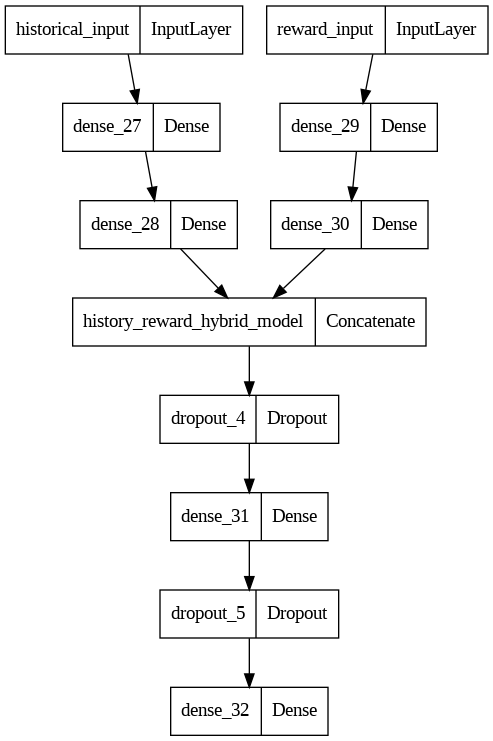

In [ ]:
# Plot hybrid model
from keras.utils import plot_model
plot_model(model_6_2)

In [ ]:
# Fit the model
model_6_2.fit(train_hybrid_dataset,
              epochs=100,
              batch_size=128,
              verbose=0,
              validation_data=test_hybrid_dataset,
              callbacks=[create_model_checkpoint(model_name=model_6_2.name)])

In [ ]:
# Make sure best model is loaded and evaluate
model_6_2 = load_model("content/model_experiments/model_6_hybrid_dense_multivariate")
model_6_2.evaluate(test_hybrid_dataset)

5/5 [==============================] - 0s 4ms/step - loss: 8698.0713


8698.0712890625

In [ ]:
# Make predictions on multivariate data
model_6_2_preds = tf.squeeze(model_6_2.predict(test_hybrid_dataset))
model_6_2_preds[:10]

5/5 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([5207.66  , 5145.5396, 5168.4253, 5105.5986, 5113.686 , 5055.8906,
       4997.2656, 4958.0967, 4939.848 , 4900.6543], dtype=float32)>

In [ ]:
# Evaluate predictions
model_6_2_results = evaluate_preds(y_true=hybrid_y_test,
                                   y_preds=model_6_2_preds)
model_6_2_results

{'mae': 8698.071,
 'mse': 134127600.0,
 'rmse': 11581.347,
 'mape': 43.065857,
 'mase': 15.280102}

In [ ]:
# View how do model_6_2 results compare to model_1, model_6, and model_6_1
print(model_1_results)
print(model_6_results)
print(model_6_1_results)

{'mae': 567.85114, 'mse': 1173786.4, 'rmse': 1083.4142, 'mape': 2.5389447, 'mase': 0.99755716}
{'mae': 563.8943, 'mse': 1159228.0, 'rmse': 1076.6746, 'mape': 2.5256484, 'mase': 0.99060607}
{'mae': 568.8962, 'mse': 1162402.8, 'rmse': 1078.1478, 'mape': 2.546071, 'mase': 0.99939305}


This model_6_2 performs poorly, and model_6 now serves to perform best among all models.

## Model 7: N-BEATS algorithm
we're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)
![](https://camo.githubusercontent.com/4a9606f328443804f3e0eb99a881b54dadbb081ea2ec2335d1f20949b68c519d/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f31302d6669677572652d312d6e62656174732d70617065722d616e6e6f74617465642e706e67)

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Doing this will give us an opportunity to practice:
- Creating a custom layer for the NBeatsBlock by subclassing tf.keras.layers.Layer
    * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
- Implementing a custom architecture using the Functional API
- Finding a paper related to our problem and seeing how it goes

In [ ]:
from keras.layers import Layer

# Create NBeatsBlock custom layer
class NBeatsBlock(Layer):

    def __init__(self,  # the constructor takes all the hyperparameters for the layer
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs):  # the **kwargs argument takes core of all of the arguments for the parent class
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each haas ReLU activation
        self.hidden = [Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta layerwith linear activation
        self.theta_layer = Dense(theta_size, activation="linear", name="theta")


    def call(self, inputs):

        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,  # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WIDNOW_SIZE) + 1, axis=0)  # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

### Preparing data for the N-BEATS algorithm using tf.data

In [ ]:
HORIZON = 1  # how for to predict forward
WINDOW_SIZE = 7  # how for to lookback

In [ ]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

### Setting up hyperparameters for N-BEATS algorithm

Table 18/Appendix D
![](https://camo.githubusercontent.com/8cfd3469b4fc083f3f8375726d64b5afc800b7c0f393b91648558c0cfa5d1dcf/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f31302d6e62656174732d7461626c652d31382d6879706572706172616d65746572732e706e67)

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000  # called "Iterations" in Table 18
N_NEURONS = 512  # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON  # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

### Getting ready for residual connections

They're what make N-BEATS double residual stacking (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:

- `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
- `tf.keras.layers.add(inputs)` - adds list of input tensors to each other


In [ ]:
from keras.layers import subtract, add

# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = subtract([tensor_1, tensor_2])

# Add
added = add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

### Building, compiling and fitting the N-BEATS algorithm

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS - 1)):  # first stack is already created in (3)

    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals)  # pass it in residuals (the backcast)

    # 6. Create the double residual stacking
    residuals = subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = Model(inputs=stack_input,
                outputs=forecast,
                name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=Adam(0.001),
                metrics=["mae", "mse"])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 8.1 Create callbacks
callbacks = [EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
             ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)]

In [ ]:
# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,  # prevent large amounts of training outputs
            # callbacks = [create_model_checkpoint(model_name=model_7.name)]  # saving movel every epoch
            callbacks=callbacks)

In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [ ]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

### Plotting the N-BEATS architecture we've created

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from keras.utils import plot_model
plot_model(model_7)

In [ ]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

## Model 8: Creating an ensemble (stacking different models together)

To create our ensemble models we're going to be using a combination of:

- Different loss functions (MAE, MSE, MAPE)
- Randomly initialized models


### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_enseble_models(horizon=HORIZON,
                       train_data=train_dataset,
                       test_data=test_dataset,
                       num_iter=10,
                       num_epochs=100,
                       loss_fns=["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

    For example, if num_iter=10, a list of 30 trined models will be returned:
    10 * len(["mae", "mse", "mape"]).
    """
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_functino} for {num_epochs} epochs, model number: {i}")

            # Construct a simple model (similar to model_1)
            model = Sequential([
                # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
                # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(HORIZON)
            ])

            # Compile simple model with current loss function
            model.compile(loss=loss_function,
                          optimizer=Adam(),
                          metrics["mae", "mse"])

            # Fit model
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=test_data,
                      # Add callbacks to prevent training from going/stalling for too long
                      callbacks=[EarlyStopping(monitor="val_loss",
                                               patience=200,
                                               restore_best_weights=True),
                                 ReduceLROnPlateau(monitor="val_loss",
                                                   patience=100,
                                                   verbose=1)])

            # Append fitted model to list of ensemble models
            ensemble_models.append(model)

    return ensemble_models  # return list of trained models

In [ ]:
%%time
# Get list of tained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

### Making predictions with an ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)  # make predictions with current ensemble model
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

In [ ]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))  # take the median across all ensemble predictions
 ensemble_results

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_lower_upper(preds):  # 1. Take the predictions of multiple randomly initialized deep learning neural networks

    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)

    # 3. Multiply the standard deviation by 1.96
    interval = 1.96 * std  # https://en.wikipedia.org/wiki/1.96

    # 4. Get the prediction interval upper and lower bounds
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return lower, upper

# Get the lower and upper bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))

plt.plot(X_test.index[offset:], y_test[offset:], 'g', label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label="Ensemble Median")

plt.xlabel("Date")
plt.ylabel("BTC Price")

plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

## Model 9: Train a model on the full historical data to make predictions into future

In [ ]:
bitcoin_prices_windowed.head()

In [ ]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()  # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_window.drop_na()["Price"].to_numpy()

In [ ]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SZIE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
from keras.losses import mae

tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = Sequential([
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(HORIZON)
])

# Compile
model_9.compile(loss=mae,
                optimizer=Adam())

In [ ]:
# Fit the model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)  # don't print out anything, we've seen this all before

### Make predictions on the future

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14  # since our Bitcoin data is daily, this is for 14 days

In [ ]:
# 1. Createa function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Makes future forecasts into_future steps aftre values ends.

    Returns future forecasts as list of floats.
    """
    # 2. Make an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]  # only want preds from the last window (this will get updated)

    # 3. Make INTO_FUTURE number of predictions, altering the ata which gets predicted on each time
    for _ in range(into_future):

        # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())
        # print(future_forecast)

        # Update last window with new pred and get window_size most recent preds (model was trained on window_size windows)
        last_window = np.append(last_window, future_pred)[-window_size:]

        # Exercise for retrain model after prediction
        model.fit(last_window,
                  epochs=1,
                  verbose=0)

    return future_forecast

In [ ]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
# Let see on future forecast
future_forecast[:10]

### Plot future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
    """
    Returns array of datetime values from ranging from start_date to start_date + horizon.

    :param start_date: data to start range (np.datatime64);
    :param into_future: number of days to add onto start date for range (int);
    :param offset: number of days to offset start_date by (default 1);
    :return: a date range between start date and end date.
    """
    start_date = start_date + np.timedelta64(offset, 'D')  # specify start date, "D" stands for day
    end_date = start_date + np.timedelta64(into_future, 'D')  # specify end date

    return np.arange(start_date, end_date, dtype="datetime64['D']")

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_time_step)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format='-', label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format='-', label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [ ]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

In [ ]:
# Plot our artificially created turkey problem Bitcoin data
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format='-',
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

### Building a turkey model (model to predict on turkey data)

In [ ]:
from keras.models import clone_model

# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = clone_model(model_1)
turkey_model._name = "Turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=Adam())

In [ ]:
# Fit the model
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callback=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

In [ ]:
from keras.models import load_model

# Load best model and evaluate on test data
turkey_model = load_model("model_experiments/Turkey_model")
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

In [ ]:
# Evaluate turkey predictions
turkey_results = evaluate_preds(y_true=y_test,
                                y_preds=turkey_preds)
turkey_results

In [ ]:
# View on model 1 results
model_1_results

In [ ]:
# Visualize the turkey predictions over the test turkey data
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:splits], label="Train Data")
offset = 300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format='-',
                 label="Turkey Test Data", start=offset)

plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset)

## Compare Models

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_Conv1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")

## Exercises

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)

- Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).

- You can download the Bitcoin historical data for free from [coindesk.com/price/bitcoin](https://www.coindesk.com/price/bitcoin) and clicking "Export Data" -> "CSV".

3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?

- Setup a series of experiments to find whether or not there's a better window size.
- For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

4. Create a windowed dataset just like the ones we used for model_1 using tf.keras.preprocessing.timeseries_dataset_from_array() and retrain model_1 using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.

- Are there any other features you think you could add?
- If so, try it out, how do these affect the model?

6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (model_9)?
8. Throughout this notebook, we've only tried algorithms we've handcrafted ourselves. But it's worth seeing how a purpose built forecasting algorithm goes.

- Try out one of the extra algorithms listed in the modelling experiments part such as:
    * [Facebook's Kats library](https://github.com/facebookresearch/Kats) - there are many models in here, remember the machine learning practioner's motto: experiment, experiment, experiment.
    * [LinkedIn's Greykite library](https://github.com/linkedin/greykite)

### Exercise - 1

### Exercise - 2

### Exercise - 3

### Exercise - 4

### Exercise - 5

### Exercise - 6

### Exercise - 7

### Exercise - 8